<a href="https://colab.research.google.com/github/peterruler/cancer-cnn/blob/main/Breast_Cancer_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:




# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# import kagglehub
# paultimothymooney_breast_histopathology_images_path = kagglehub.dataset_download('paultimothymooney/breast-histopathology-images')
# awsaf49_cbis_ddsm_breast_cancer_image_dataset_path = kagglehub.dataset_download('awsaf49/cbis-ddsm-breast-cancer-image-dataset')
# cheddad_miniddsm2_path = kagglehub.dataset_download('cheddad/miniddsm2')

# print('Data source import complete.')


https://www.kaggle.com/code/baselanaya/breast-cancer-detection-using-cnn

# Breast Cancer Detection using CNN


### Summary of the CBIS-DDSM Dataset Description:

The CBIS-DDSM (Curated Breast Imaging Subset of DDSM) dataset is a collection of medical images in JPEG format, derived from the original dataset which was 163GB in size. The resolution of the images in the CBIS-DDSM dataset has been maintained to match that of the original dataset. This dataset is primarily focused on breast imaging for mammography.

### Key Dataset Statistics:

* `Number of Studies:` 6,775
* `Number of Series:` 6,775
* `Number of Participants:` 1,566 (Note: The dataset's structure results in multiple patient IDs per participant, making it appear as if there are 6,671 patients according to DICOM metadata, but there are actually 1,566 distinct participants.)
* `Number of Images:` 10,239
* `Modality:` MG (Mammography)
* `Image Size:` 6 GB in JPEG format

### Dataset Description:
The CBIS-DDSM dataset is an updated and standardized version of the Digital Database for Screening Mammography (DDSM). The DDSM originally consisted of 2,620 scanned film mammography studies, encompassing normal, benign, and malignant cases with verified pathology information. The dataset's large scale and comprehensive ground truth data make it valuable for developing and testing decision support systems in mammography.

The CBIS-DDSM collection is a carefully selected subset of the DDSM data, curated by a trained mammographer. The images have been decompressed and converted to DICOM format, and the dataset includes updated ROI (Region of Interest) segmentation and bounding boxes, as well as pathologic diagnosis information for training data.

Researchers and practitioners in the field of mammography have faced challenges in replicating research results due to the lack of a standardized evaluation dataset. Most computer-aided diagnosis (CADx) and detection (CADe) algorithms for breast cancer in mammography rely on private datasets or unspecified subsets of public databases. The CBIS-DDSM dataset addresses this challenge by providing a well-curated, publicly accessible, and standardized version of the DDSM for future CAD research in mammography.

It is important to note that the dataset's structure assigns multiple patient IDs to each participant, which can be misleading. For instance, a participant may have 10 separate patient IDs, each containing information about different scans. Despite this, there are only 1,566 actual participants in the cohort.

For scientific inquiries about the CBIS-DDSM dataset, researchers can contact Dr. Daniel Rubin from the Department of Biomedical Data Science, Radiology, and Medicine at Stanford University School of Medicine via email at dlrubin@stanford.edu.

Additional details on how to use this dataset can be found in a manuscript available at https://www.nature.com/articles/sdata2017177.

In [10]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
import glob
import sys

def _count_dataset_images(root_path):
    total_count = 0
    counts_per_dataset = {}

    # 1. breast-histopathology-images
    # Path: <root_path>/breast-histopathology-images/**/*.png
    dataset1_name = 'breast-histopathology-images'
    path1 = os.path.join(root_path, dataset1_name)
    current_dataset_count = 0
    if os.path.exists(path1):
        pattern1 = os.path.join(path1, '**', '*.png')
        files1 = glob.glob(pattern1, recursive=True)
        current_dataset_count = len(files1)
        print(f"Found {current_dataset_count} images in {path1}")
    else:
        print(f"Directory not found: {path1}")
    total_count += current_dataset_count
    counts_per_dataset[dataset1_name] = current_dataset_count

    # 2. MINI-DDSM-Complete-PNG-16
    # Path: <root_path>/MINI-DDSM-Complete-PNG-16/[Benign|Cancer]/<4 digits number>/<image name.png>
    dataset2_name = 'MINI-DDSM-Complete-PNG-16'
    path2_base = os.path.join(root_path, dataset2_name)
    current_dataset_count = 0
    if os.path.exists(path2_base):
        # Count Benign
        pattern2a = os.path.join(path2_base, 'Benign', '????', '*.png') # Assuming .png extension
        files2a = glob.glob(pattern2a)
        current_dataset_count += len(files2a)
        print(f"Found {len(files2a)} images in {os.path.join(path2_base, 'Benign', '????')}")

        # Count Cancer
        pattern2b = os.path.join(path2_base, 'Cancer', '????', '*.png') # Assuming .png extension
        files2b = glob.glob(pattern2b)
        current_dataset_count += len(files2b)
        print(f"Found {len(files2b)} images in {os.path.join(path2_base, 'Cancer', '????')}")
    else:
        print(f"Directory not found: {path2_base}")
    total_count += current_dataset_count
    counts_per_dataset[dataset2_name] = current_dataset_count

    # 3. cbis-ddsm-breast-cancer-image-dataset
    # Path: <root_path>/cbis-ddsm-breast-cancer-image-dataset/jpeg/<name like ...>/<imagename.jpg>
    dataset3_name = 'cbis-ddsm-breast-cancer-image-dataset'
    path3_base = os.path.join(root_path, dataset3_name, 'jpeg')
    current_dataset_count = 0
    if os.path.exists(path3_base):
        pattern3 = os.path.join(path3_base, '*', '*.jpg') # Assuming .jpg extension
        files3 = glob.glob(pattern3)
        current_dataset_count = len(files3)
        print(f"Found {current_dataset_count} images in {path3_base}")
    else:
        print(f"Directory not found: {os.path.join(root_path, dataset3_name, 'jpeg')} (or {os.path.join(root_path, dataset3_name)} is missing)")
    total_count += current_dataset_count
    counts_per_dataset[dataset3_name] = current_dataset_count

    print("\nSummary of counts per dataset:")
    for name, count in counts_per_dataset.items():
        print(f"- {name}: {count}")
    print("---")
    return total_count

def count_images_local(root_dir):
    print(f"Counting local images from root directory: {root_dir}")
    return _count_dataset_images(root_dir)

def count_images_gdrive(root_dir):
    print(f"Counting Google Drive images from root directory: {root_dir}")
    return _count_dataset_images(root_dir)

def is_on_gdrive():
    # Check if running in Google Colab or if /drive exists
    return os.path.exists('/content/drive') or os.path.exists('/drive')

def main():
    # Define root paths for datasets.
    # These paths should be the PARENT directory of
    # 'breast-histopathology-images', 'MINI-DDSM-Complete-PNG-16', etc.
    local_datasets_root = os.getcwd()
    # Example: If script is in /Projects/cnn-pytorch-breastcancer, and datasets are in
    # /Projects/cnn-pytorch-breastcancer/breast-histopathology-images, etc.

    gdrive_datasets_root = '/content/drive/My Drive/dl-udemy'
    # Example: Parent folder on GDrive containing the dataset folders.

    if is_on_gdrive():
        print(f"Detected Google Drive environment. Using root for datasets: {gdrive_datasets_root}")
        if not os.path.exists(gdrive_datasets_root):
            print(f"Google Drive datasets root path not found: {gdrive_datasets_root}")
            print("Please ensure Google Drive is mounted and the path is correct.")
            count = 0
        else:
            count = count_images_gdrive(gdrive_datasets_root)
        print(f"\nTotal images found across all datasets in Google Drive: {count}")
    else:
        print(f"Google Drive not detected. Using local root for datasets: {local_datasets_root}")
        if not os.path.exists(local_datasets_root):
            print(f"Local datasets root path not found: {local_datasets_root}")
            print("Ensure the script is run from the correct directory or adjust 'local_datasets_root'.")
            count = 0
        else:
            count = count_images_local(local_datasets_root)
        print(f"\nTotal images found across all local datasets: {count}")

if __name__ == '__main__':
    main()

# Total images locally: 555048
# Detected Google Drive environment.
# Total images in Google Drive: 196509

# Should be
# Summary of counts per dataset:
# - breast-histopathology-images: 555048
# - MINI-DDSM-Complete-PNG-16: 5894
# - cbis-ddsm-breast-cancer-image-dataset: 10237
# ---
# present nr of images:
# Summary of counts per dataset:
# - breast-histopathology-images: 555097
# - MINI-DDSM-Complete-PNG-16: 5894
# - cbis-ddsm-breast-cancer-image-dataset: 9978
# ---

Detected Google Drive environment. Using root for datasets: /content/drive/My Drive/dl-udemy
Counting Google Drive images from root directory: /content/drive/My Drive/dl-udemy
Found 555097 images in /content/drive/My Drive/dl-udemy/breast-histopathology-images
Found 2893 images in /content/drive/My Drive/dl-udemy/MINI-DDSM-Complete-PNG-16/Benign/????
Found 3001 images in /content/drive/My Drive/dl-udemy/MINI-DDSM-Complete-PNG-16/Cancer/????
Found 9978 images in /content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/jpeg

Summary of counts per dataset:
- breast-histopathology-images: 555097
- MINI-DDSM-Complete-PNG-16: 5894
- cbis-ddsm-breast-cancer-image-dataset: 9978
---

Total images found across all datasets in Google Drive: 570969


In [13]:
import pandas as pd
import os
# Path to the dataset folder
base_path_csv = '/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/csv'

image_dir = '/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/jpeg'
# CSV file path
csv_path = os.path.join(base_path_csv, 'dicom_info.csv')

# Load the CSV
dicom_data = pd.read_csv(csv_path)

In [14]:
# dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
# image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [15]:
dicom_data.head()

file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   
3  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
4  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   

                                          image_path  AccessionNumber  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   
3  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   
4  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   

   BitsAllocated  BitsStored BodyPartExamined  Columns  ContentDate  \
0             16          16           BREAST      351     20160426   
1             16          16           BREAST     3526     20160426   
2             16          16           BREAST     1546     20160503   
3             16          16           BREAST       97     20160503   
4              8           8      Left Breast     3104     20160503   

   ContentTime ConversionType  ...  \
0   131732.685            WSD  ...   
1   143829.101            WSD  ...   
2   111956.298            WSD  ...   
3   115347.770            WSD  ...   
4   115347.770            WSD  ...   

   SecondaryCaptureDeviceManufacturerModelName      SeriesDescription  \
0                                       MATLAB         cropped images   
1                                       MATLAB  full mammogram images   
2                                       MATLAB  full mammogram images   
3                                       MATLAB         cropped images   
4                                       MATLAB                    NaN   

                                   SeriesInstanceUID SeriesNumber  \
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007...            1   
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309...            1   
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918...            1   
3  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   
4  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   

  SmallestImagePixelValue  SpecificCharacterSet   StudyDate StudyID  \
0                   23078            ISO_IR 100  20160720.0    DDSM   
1                       0            ISO_IR 100  20160720.0    DDSM   
2                       0            ISO_IR 100  20160807.0    DDSM   
3                   32298            ISO_IR 100  20170829.0    DDSM   
4                       0            ISO_IR 100         NaN    DDSM   

                                    StudyInstanceUID  StudyTime  
0  1.3.6.1.4.1.9590.100.1.2.271867287611061855725...   214951.0  
1  1.3.6.1.4.1.9590.100.1.2.161516517311681906612...   193426.0  
2  1.3.6.1.4.1.9590.100.1.2.291043622711253836701...   161814.0  
3  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...   180109.0  
4  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...        NaN  

[5 rows x 38 columns]

In [16]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [17]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [18]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images.head()

0     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
3     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
6     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
7     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
10    /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
Name: image_path, dtype: object

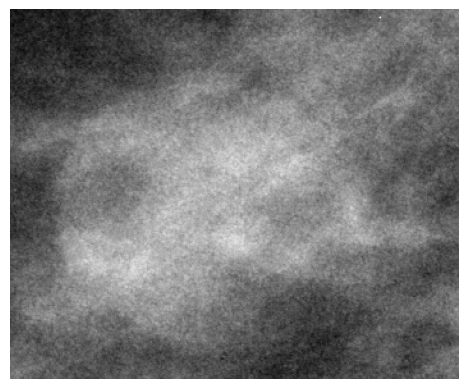

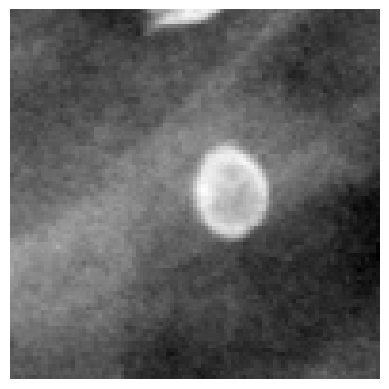

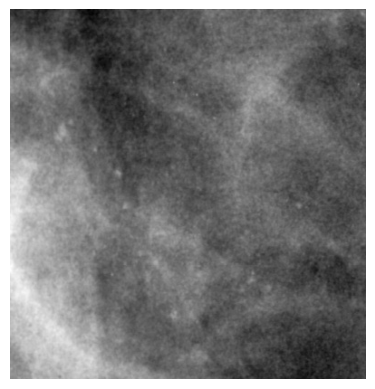

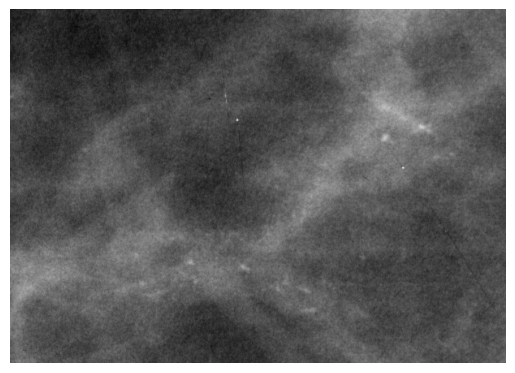

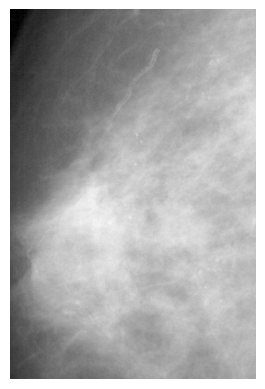

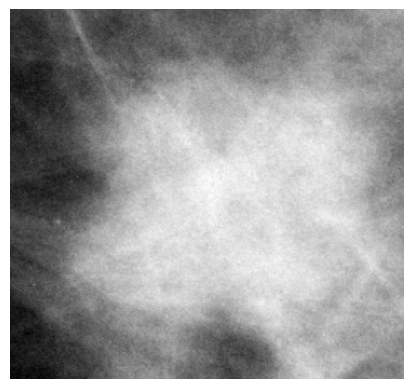

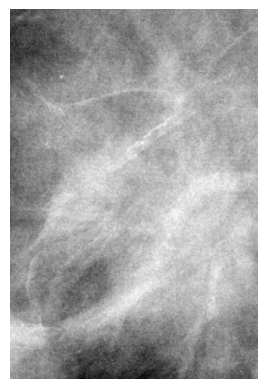

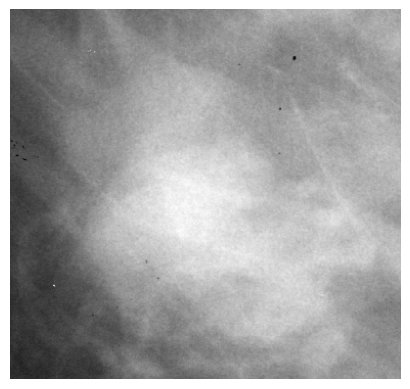

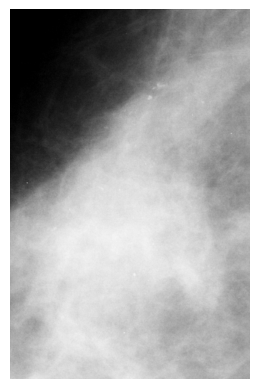

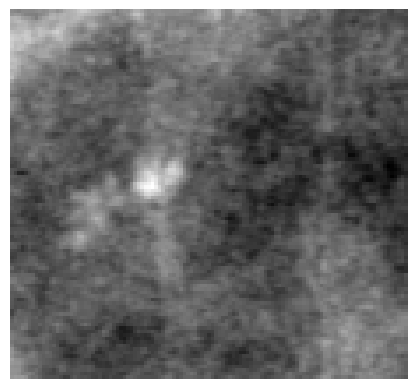

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
for file in cropped_images[0:10]:
    cropped_images_show = Image.open(file)  # ✅ no PIL. prefix here
    gray_img = cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')
    plt.axis('off')
    plt.show()

In [20]:
# for file in cropped_images[0:10]:
#error    cropped_images_show = PIL.Image.open(file)
#    gray_img= cropped_images_show.convert("L")
#    plt.imshow(gray_img, cmap='gray')

In [21]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [22]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
2     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
11    /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
12    /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
15    /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
Name: image_path, dtype: object

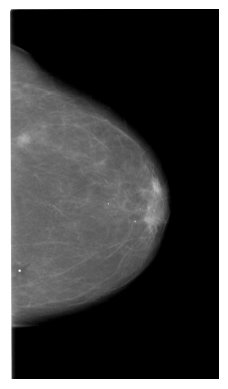

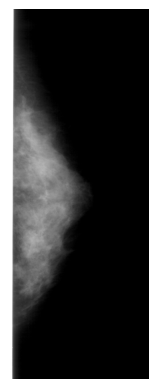

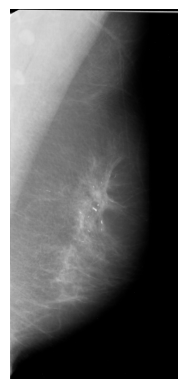

File not found: /content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.74956658311383957201426978750903861062/1-248.jpg


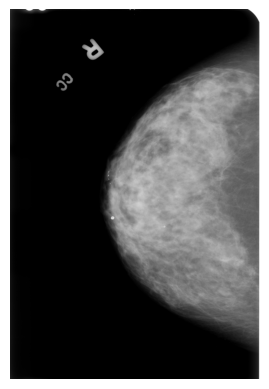

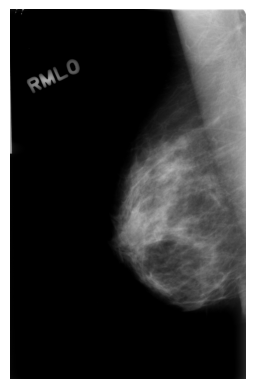

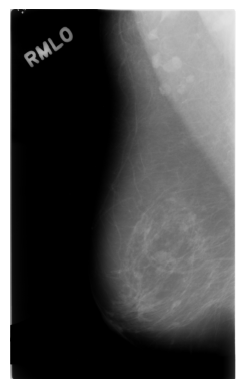

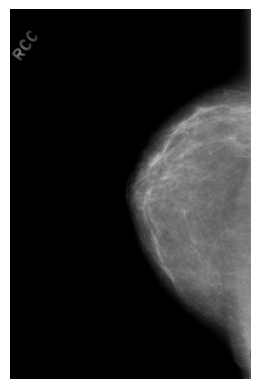

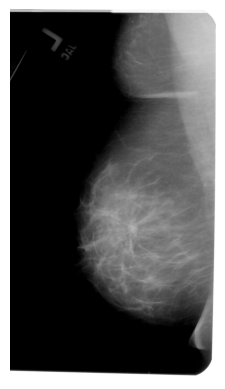

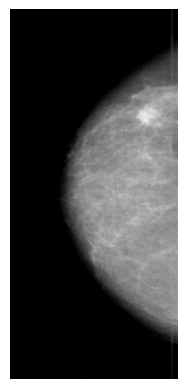

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Define base directory where the JPEGs are stored
base_dir = "/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/jpeg"

# Loop through files and open images
for file in full_mammogram_images[0:10]:
    file_path = os.path.join(base_dir, file)  # 👈 construct full path
    if os.path.exists(file_path):
        img = Image.open(file_path).convert("L")
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        print(f"File not found: {file_path}")



In [24]:
#for file  in full_mammogram_images[0:10]:
#error     full_mammogram_images_show = PIL.Image.open(file)
#    gray_img= full_mammogram_images_show.convert("L")
#    plt.imshow(gray_img, cmap='gray')

In [25]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [26]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
8     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
9     /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
14    /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
20    /content/drive/My Drive/dl-udemy/cbis-ddsm-bre...
Name: image_path, dtype: object

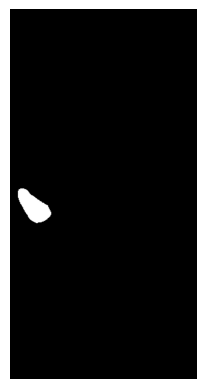

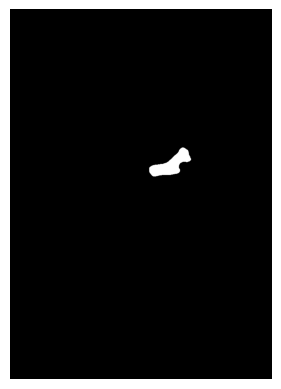

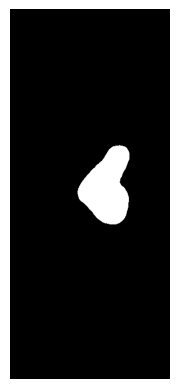

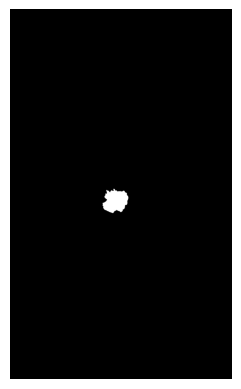

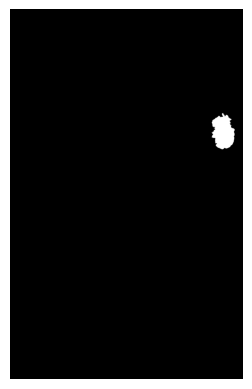

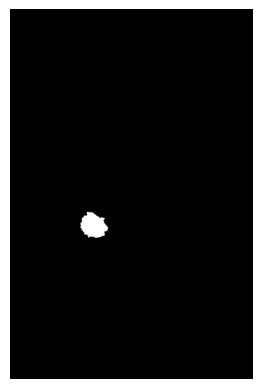

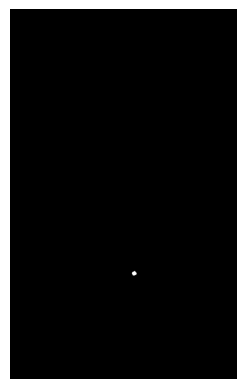

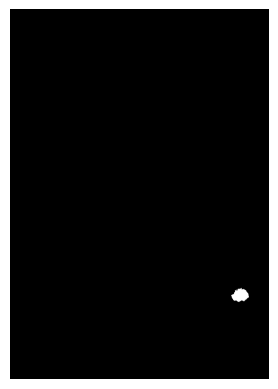

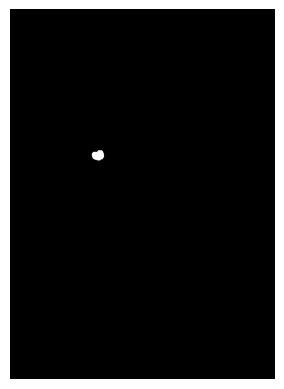

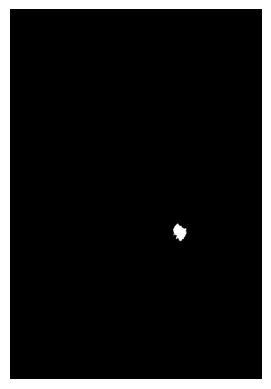

In [27]:
# Define the base path if ROI_mask_images contains only filenames
base_path = '/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/masks'

for file in ROI_mask_images[0:10]:
    file_path = os.path.join(base_path, file)  # full path to the image
    if os.path.exists(file_path):
        img = Image.open(file_path).convert("L")  # ✅ no PIL. prefix here
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.show()
    else:
        print(f"Missing file: {file_path}")


In [28]:
#for file  in ROI_mask_images[0:10]:
#error    ROI_mask_images_show = PIL.Image.open(file)
#    gray_img= ROI_mask_images_show.convert("L")
#    plt.imshow(gray_img, cmap='gray')

---

In [29]:
# calc_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_case_df = pd.read_csv('/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')

In [30]:
calc_case_df.head(5)

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image file path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped image file path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI mask file path  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...

In [31]:
# mass_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_case_df = pd.read_csv('/content/drive/My Drive/dl-udemy/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')

In [32]:
mass_case_df.head(5)

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   

                             cropped image file path  \
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   

                                  ROI mask file path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

### Data Cleaning

In [33]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   
3  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
4  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   

                                          image_path  AccessionNumber  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   
3  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   
4  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   

   BitsAllocated  BitsStored BodyPartExamined  Columns  ContentDate  \
0             16          16           BREAST      351     20160426   
1             16          16           BREAST     3526     20160426   
2             16          16           BREAST     1546     20160503   
3             16          16           BREAST       97     20160503   
4              8           8      Left Breast     3104     20160503   

   ContentTime ConversionType  ...  \
0   131732.685            WSD  ...   
1   143829.101            WSD  ...   
2   111956.298            WSD  ...   
3   115347.770            WSD  ...   
4   115347.770            WSD  ...   

   SecondaryCaptureDeviceManufacturerModelName      SeriesDescription  \
0                                       MATLAB         cropped images   
1                                       MATLAB  full mammogram images   
2                                       MATLAB  full mammogram images   
3                                       MATLAB         cropped images   
4                                       MATLAB                    NaN   

                                   SeriesInstanceUID SeriesNumber  \
0  1.3.6.1.4.1.9590.100.1.2.129308726812851964007...            1   
1  1.3.6.1.4.1.9590.100.1.2.248386742010678582309...            1   
2  1.3.6.1.4.1.9590.100.1.2.267213171011171858918...            1   
3  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   
4  1.3.6.1.4.1.9590.100.1.2.381187369611524586537...            1   

  SmallestImagePixelValue  SpecificCharacterSet   StudyDate StudyID  \
0                   23078            ISO_IR 100  20160720.0    DDSM   
1                       0            ISO_IR 100  20160720.0    DDSM   
2                       0            ISO_IR 100  20160807.0    DDSM   
3                   32298            ISO_IR 100  20170829.0    DDSM   
4                       0            ISO_IR 100         NaN    DDSM   

                                    StudyInstanceUID  StudyTime  
0  1.3.6.1.4.1.9590.100.1.2.271867287611061855725...   214951.0  
1  1.3.6.1.4.1.9590.100.1.2.161516517311681906612...   193426.0  
2  1.3.6.1.4.1.9590.100.1.2.291043622711253836701...   161814.0  
3  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...   180109.0  
4  1.3.6.1.4.1.9590.100.1.2.335006093711888937440...        NaN  

[5 rows x 38 columns]

In [34]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True)

In [35]:
dicom_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [36]:
dicom_cleaned_data.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue                          0
SpecificCharacterSet                             0
dtype: int64

In [37]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

<ipython-input-37-51dfb01b4b86>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-37-51dfb01b4b86>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)


In [38]:
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

<ipython-input-38-82d3dade18f9>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-38-82d3dade18f9>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)


In [39]:
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet                           0
dtype: int64

In [40]:
Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')
Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [41]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1.isna().sum()

<ipython-input-41-edf8af0774e3>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-41-edf8af0774e3>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-41-edf8af0774e3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chai

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [42]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [43]:
Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_2.isna().sum()

<ipython-input-43-a75ac5a26e50>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-43-a75ac5a26e50>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-43-a75ac5a26e50>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through ch

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

---

### Data Visualization

In [44]:
# breast_imgs = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)
breast_imgs = glob.glob('/content/drive/My Drive/dl-udemy/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [45]:
for imgname in breast_imgs[:5]:
    print(imgname)

/content/drive/My Drive/dl-udemy/breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x951_y551_class0.png
/content/drive/My Drive/dl-udemy/breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1151_y551_class0.png
/content/drive/My Drive/dl-udemy/breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1151_y1001_class0.png
/content/drive/My Drive/dl-udemy/breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x1251_y701_class0.png
/content/drive/My Drive/dl-udemy/breast-histopathology-images/IDC_regular_ps50_idx5/10253/0/10253_idx5_x2051_y1251_class0.png


In [46]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0' :
        non_cancer_imgs.append(img)

    elif img[-5] == '1' :
        cancer_imgs.append(img)

In [47]:
non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer

total_img_num = non_cancer_num + cancer_num

print('Number of Images of no cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(cancer_num))   # images of cancer
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 198738
Number of Images of cancer : 78786
Total Number of Images : 277524


In [48]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [198738,78786]})

In [49]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
bar.show()

In [50]:
r= pd.DataFrame(dicom_cleaned_data['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

SeriesDescription_counts  count
0           cropped images   3859
1          ROI mask images   3340
2    full mammogram images   3038

In [51]:
ba_1 = px.bar(data_frame=dicom_cleaned_data, x='SeriesDescription', color='SeriesDescription',
              title='Types of images used')
ba_1.update_layout(title_text='Types of images used', title_x=0.5)
ba_1.show()

from cbis-ddsm-breast-cancer-image-dataset : This study depends on Three types of images ; `cropped images` , `ROI images` , `Full mammogram images` . from this graph we conclude that `cropped images` is the most used between them

In [52]:
f= pd.DataFrame(dicom_cleaned_data['BodyPartExamined'].value_counts())
f= f.reset_index()
f= f.rename(columns={'BodyPartExamined':'BodyPartExamined_counts', 'index':'Breast part Examined'})
f

BodyPartExamined_counts  count
0                  BREAST   9671
1             Left Breast    318
2            Right Breast    248

In [53]:
ba = px.bar(data_frame=f, x="BodyPartExamined_counts", y="count", color="BodyPartExamined_counts")
ba.update_layout(title_text='Breast Parts Examined', title_x=0.5, yaxis=dict(type='log'))
ba.show()

**The Most Part Examined is Breast "All" = left and also right**

In [54]:
data_insight_2 = pd.DataFrame({'abnormality':[Data_cleaning_1.abnormality_type[0],Data_cleaning_2.abnormality_type[0]],
                               'counts_of_abnormalties':[len(Data_cleaning_1),len(Data_cleaning_2)]})
data_insight_2

abnormality  counts_of_abnormalties
0  calcification                    1546
1           mass                    1318

In [55]:
bar_2 =px.bar(data_frame=data_insight_2, x = 'abnormality', y='counts_of_abnormalties', color = 'abnormality')
bar_2.update_layout(title_text='Types of abnormalites of cancer', title_x=0.5)
bar_2.show()

from this graph:
There are two abnormalities of breast cancer:
- Calcification abnormality
- Mass abnormality

**Most cases are with calcification abnormalities**

In [56]:
x = Data_cleaning_1.left_or_right_breast.value_counts().RIGHT
y = Data_cleaning_1.left_or_right_breast.value_counts().LEFT
print(x,y)

728 818


In [57]:
data_insight_3 = pd.DataFrame({'left_or_right_breast':['RIGHT','LEFT'] , 'Counts':[x,y]})
data_insight_3

left_or_right_breast  Counts
0                RIGHT     728
1                 LEFT     818

In [58]:
insight_3 = px.bar(data_insight_3, y= 'Counts', x='left_or_right_breast',color = 'left_or_right_breast')
insight_3.update_layout(title_text=' clacification cancer position of the breasts ', title_x=0.5)
insight_3.show()

**For calcification cancer, most cases are usually in the left breast.**

In [59]:
z = pd.DataFrame(Data_cleaning_1['calc_type'].value_counts())
z = z.reset_index()
z= z.rename(columns={'calc_type':'calc_type_counts'})
z

calc_type_counts  count
0                                         PLEOMORPHIC    664
1                                           AMORPHOUS    139
2                                            PUNCTATE    106
3                                       LUCENT_CENTER     93
4                                            VASCULAR     82
5                               FINE_LINEAR_BRANCHING     77
6                                              COARSE     35
7                     ROUND_AND_REGULAR-LUCENT_CENTER     33
8                   PLEOMORPHIC-FINE_LINEAR_BRANCHING     28
9            ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE     24
10                         ROUND_AND_REGULAR-EGGSHELL     23
11                               PUNCTATE-PLEOMORPHIC     21
12                                         DYSTROPHIC     20
13                                    LUCENT_CENTERED     19
14         ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC     18
15                                  ROUND_AND_REGULAR     17
16                  ROUND_AND_REGULAR-LUCENT_CENTERED     14
17                              AMORPHOUS-PLEOMORPHIC     12
18                    LARGE_RODLIKE-ROUND_AND_REGULAR     11
19                                 PUNCTATE-AMORPHOUS     10
20             COARSE-ROUND_AND_REGULAR-LUCENT_CENTER     10
21                    VASCULAR-COARSE-LUCENT_CENTERED      8
22                             LUCENT_CENTER-PUNCTATE      8
23                                           EGGSHELL      7
24                      ROUND_AND_REGULAR-PLEOMORPHIC      7
25                                    VASCULAR-COARSE      6
26                     PUNCTATE-FINE_LINEAR_BRANCHING      6
27                         ROUND_AND_REGULAR-PUNCTATE      5
28           COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED      4
29                                      LARGE_RODLIKE      4
30                         PUNCTATE-ROUND_AND_REGULAR      4
31                                      SKIN-PUNCTATE      4
32                    SKIN-PUNCTATE-ROUND_AND_REGULAR      4
33                             PUNCTATE-LUCENT_CENTER      3
34                        AMORPHOUS-ROUND_AND_REGULAR      3
35                               COARSE-LUCENT_CENTER      2
36                                 COARSE-PLEOMORPHIC      2
37                           COARSE-ROUND_AND_REGULAR      2
38               ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS      2
39                                    MILK_OF_CALCIUM      2
40                                               SKIN      2
41  VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA...      2
42                            PLEOMORPHIC-PLEOMORPHIC      1
43                        ROUND_AND_REGULAR-AMORPHOUS      1
44                      SKIN-COARSE-ROUND_AND_REGULAR      1

**Calcification cancer has 45 types, the majority of which are PLEOMORPHIC.**

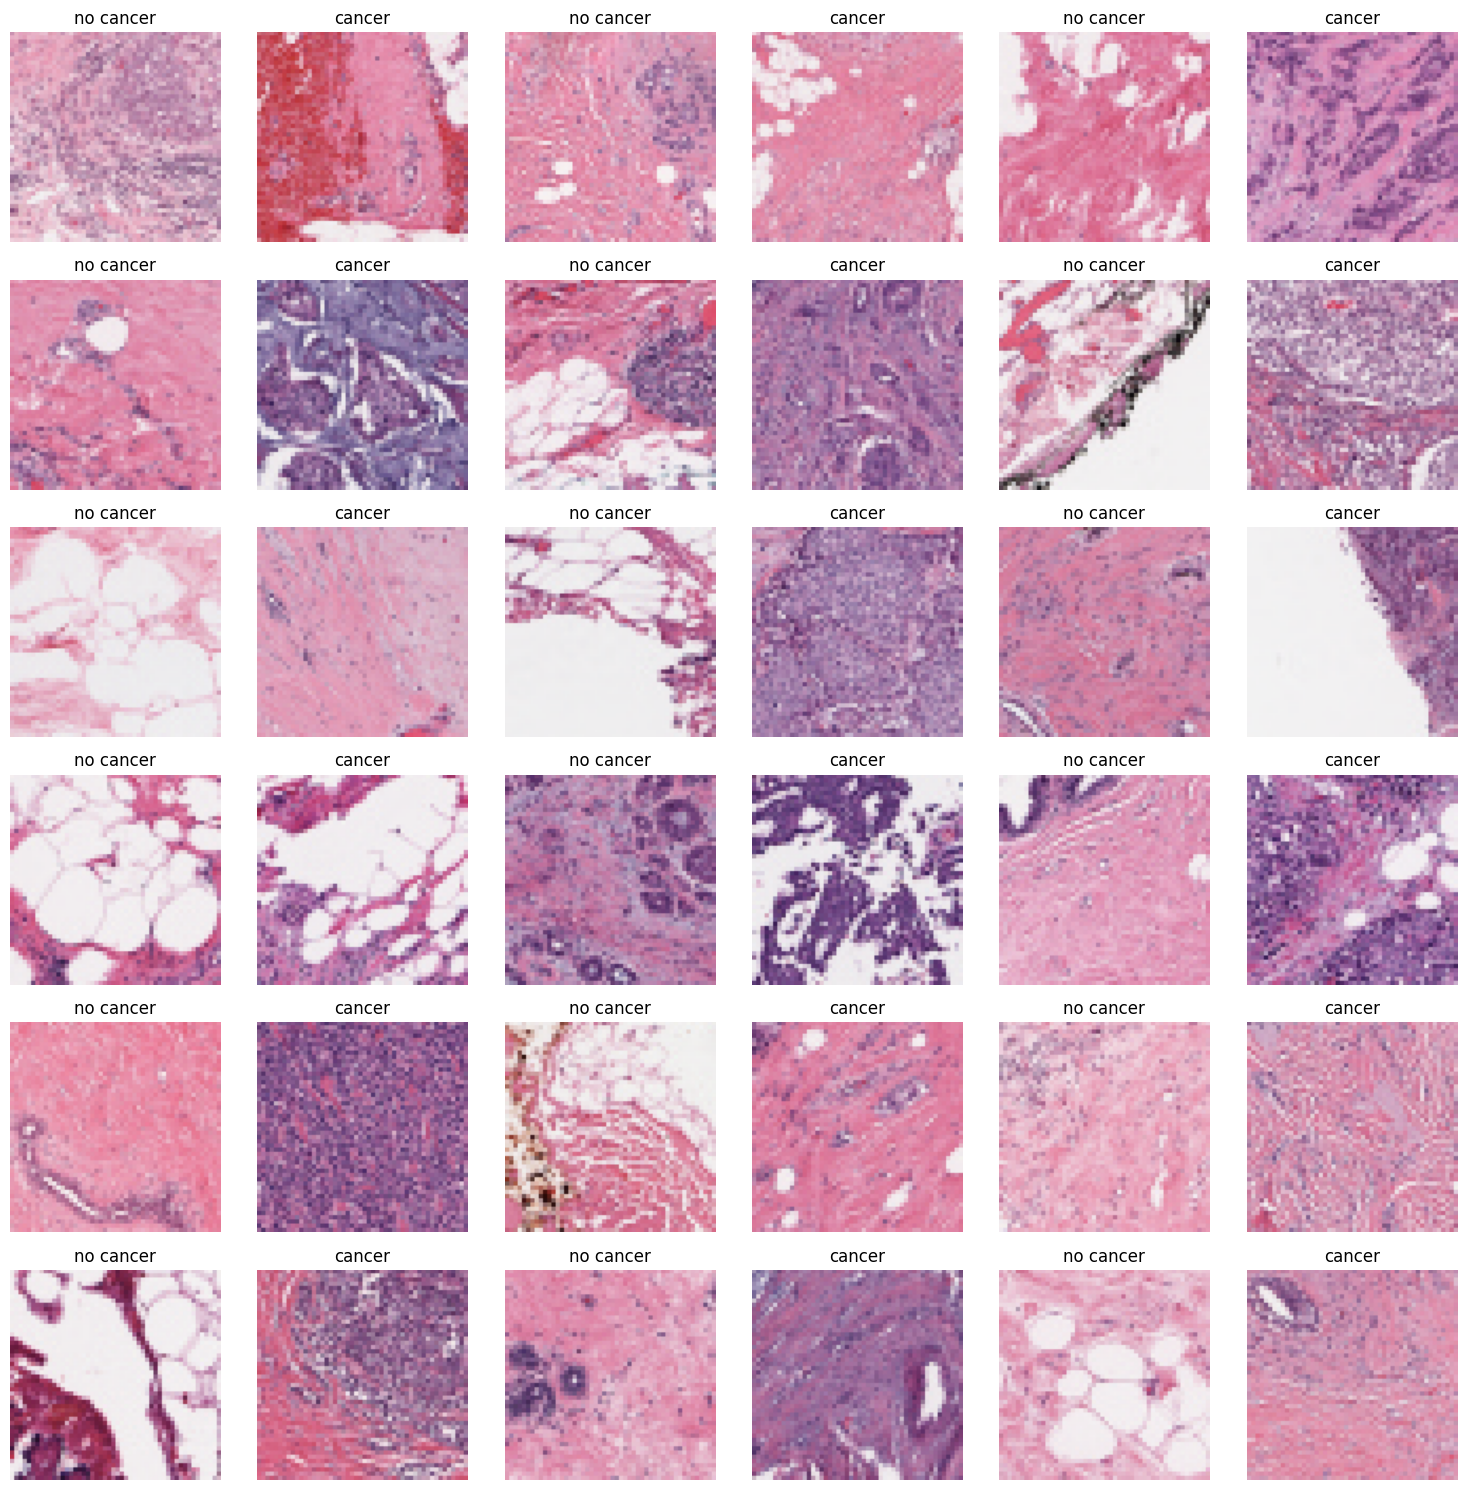

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image  # falls du Keras benutzt

plt.figure(figsize=(15, 15))

# Ziehe zufällige Indizes
some_non = np.random.randint(0, len(non_cancer_imgs), 18)
some_can = np.random.randint(0, len(cancer_imgs), 18)

# Zeige Bilder ohne Krebs (ungerade Subplot-Positionen: 1, 3, 5, ...)
for i, num in enumerate(some_non):
    img = image.load_img(non_cancer_imgs[num], target_size=(100, 100))
    img = image.img_to_array(img)

    plt.subplot(6, 6, 2*i + 1)
    plt.imshow(img.astype('uint8'))
    plt.title('no cancer')
    plt.axis('off')

# Zeige Bilder mit Krebs (gerade Subplot-Positionen: 2, 4, 6, ...)
for i, num in enumerate(some_can):
    img = image.load_img(cancer_imgs[num], target_size=(100, 100))
    img = image.img_to_array(img)

    plt.subplot(6, 6, 2*i + 2)
    plt.imshow(img.astype('uint8'))
    plt.title('cancer')
    plt.axis('off')

plt.tight_layout()
plt.show()


---
### Data Modeling

In [61]:
'''
# Randomly sample images from two lists, 'non_cancer_imgs' and 'cancer_imgs'
some_non_img = random.sample(non_cancer_imgs, len(non_cancer_imgs))
some_can_img = random.sample(cancer_imgs, len(cancer_imgs))

# Initialize empty arrays to store image data and labels
non_img_arr = []  # Array for non-cancer images
can_img_arr = []  # Array for cancer images

# Loop through each image in the 'some_non_img' list
for img in some_non_img:
    # Read the image in color mode
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 0 (indicating non-cancer) to the 'non_img_arr'
    non_img_arr.append([n_img_size, 0])

# Loop through each image in the 'some_can_img' list
for img in some_can_img:
    # Read the image in color mode
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 1 (indicating cancer) to the 'can_img_arr'
    can_img_arr.append([c_img_size, 1])
'''

"\n# Randomly sample images from two lists, 'non_cancer_imgs' and 'cancer_imgs'\nsome_non_img = random.sample(non_cancer_imgs, len(non_cancer_imgs))\nsome_can_img = random.sample(cancer_imgs, len(cancer_imgs))\n\n# Initialize empty arrays to store image data and labels\nnon_img_arr = []  # Array for non-cancer images\ncan_img_arr = []  # Array for cancer images\n\n# Loop through each image in the 'some_non_img' list\nfor img in some_non_img:\n    # Read the image in color mode\n    n_img = cv2.imread(img, cv2.IMREAD_COLOR)\n    # Resize the image to a fixed size (50x50 pixels) using linear interpolation\n    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)\n    # Append the resized image and label 0 (indicating non-cancer) to the 'non_img_arr'\n    non_img_arr.append([n_img_size, 0])\n\n# Loop through each image in the 'some_can_img' list\nfor img in some_can_img:\n    # Read the image in color mode\n    c_img = cv2.imread(img, cv2.IMREAD_COLOR)\n    # Resize th

In [62]:
import cv2
import random
import numpy as np
from concurrent.futures import ThreadPoolExecutor

IMG_SIZE = 50
NUM_IMAGES_PER_CLASS = 15000

# Shuffle and slice to limit to 10,000 images per class
random.shuffle(non_cancer_imgs)
random.shuffle(cancer_imgs)
non_cancer_imgs = non_cancer_imgs[:NUM_IMAGES_PER_CLASS]
cancer_imgs = cancer_imgs[:NUM_IMAGES_PER_CLASS]

def load_and_resize(img_path, label):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        return None  # Skip unreadable or corrupt images
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    return (img_resized, label)

# Parallel image loading using multithreading
with ThreadPoolExecutor(max_workers=12) as executor:
    non_img_arr = list(filter(None, executor.map(lambda p: load_and_resize(p, 0), non_cancer_imgs)))
    can_img_arr  = list(filter(None, executor.map(lambda p: load_and_resize(p, 1), cancer_imgs)))

# Combine and shuffle both arrays
all_data = non_img_arr + can_img_arr
random.shuffle(all_data)

# Convert to NumPy arrays
X = np.array([x[0] for x in all_data], dtype=np.uint8)
y = np.array([x[1] for x in all_data], dtype=np.uint8)

In [63]:
'''
X = []  # List for image data
y = []  # List for labels

# Concatenate the arrays 'non_img_arr' and 'can_img_arr' into a single array 'breast_img_arr'
breast_img_arr = np.concatenate((non_img_arr, can_img_arr))

# Shuffle the elements in the 'breast_img_arr' array randomly
random.shuffle(breast_img_arr)

# Loop through each element (feature, label) in the shuffled 'breast_img_arr'
for feature, label in breast_img_arr:
    # Append the image data (feature) to the 'X' list
    X.append(feature)
    # Append the label to the 'y' list
    y.append(label)

# Convert the lists 'X' and 'y' into NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the 'X' array
print('X shape: {}'.format(X.shape))
'''

"\nX = []  # List for image data\ny = []  # List for labels\n\n# Concatenate the arrays 'non_img_arr' and 'can_img_arr' into a single array 'breast_img_arr'\nbreast_img_arr = np.concatenate((non_img_arr, can_img_arr))\n\n# Shuffle the elements in the 'breast_img_arr' array randomly\nrandom.shuffle(breast_img_arr)\n\n# Loop through each element (feature, label) in the shuffled 'breast_img_arr'\nfor feature, label in breast_img_arr:\n    # Append the image data (feature) to the 'X' list\n    X.append(feature)\n    # Append the label to the 'y' list\n    y.append(label)\n\n# Convert the lists 'X' and 'y' into NumPy arrays\nX = np.array(X)\ny = np.array(y)\n\n# Print the shape of the 'X' array\nprint('X shape: {}'.format(X.shape))\n"

In [64]:
# Split the dataset into training and testing sets, with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Define a rate (percentage) for subsampling the training data
rate = 0.5

# Calculate the number of samples to keep in the training data based on the rate
num = int(X.shape[0] * rate)

# Convert the categorical labels in 'y_train' and 'y_test' to one-hot encoded format
y_train = to_categorical(y_train, 2)  # Assuming there are 2 classes (non-cancer and cancer)
y_test = to_categorical(y_test, 2)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (23998, 50, 50, 3)
X_test shape : (6000, 50, 50, 3)
y_train shape : (23998, 2)
y_test shape : (6000, 2)


In [65]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators for training and testing
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
test_datagen = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [66]:
# Define an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=5,                  # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,              # Minimum change in the monitored quantity to be considered an improvement
    restore_best_weights=True,   # Restore model weights from the epoch with the best value of monitored quantity
)

# Define a ReduceLROnPlateau callback
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor the validation loss
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,           # Number of epochs with no improvement after which learning rate will be reduced
    min_delta=1e-7,       # Minimum change in the monitored quantity to trigger a learning rate reduction
    cooldown=0,           # Number of epochs to wait before resuming normal operation after learning rate reduction
    verbose=1             # Verbosity mode (1: update messages, 0: no messages)
)

In [67]:
# Set a random seed for reproducibility
tf.random.set_seed(42)

# Create a Sequential model
model = tf.keras.Sequential([
    # Convolutional layer with 32 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 2x2 pool size and default stride (2)
    tf.keras.layers.MaxPooling2D(strides=2),

    # Convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    # Flatten the output to prepare for fully connected layers
    tf.keras.layers.Flatten(),

    # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # Output layer with 2 units (binary classification) and softmax activation
    tf.keras.layers.Dense(2, activation='softmax')
])

# Display a summary of the model architecture
model.summary()

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,162 (1.18 MB)

 Trainable params: 307,458 (1.17 MB)

 Non-trainable params: 704 (2.75 KB)

In [68]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 25,
                    batch_size = 75,
                    callbacks=[early_stopping, plateau])

Epoch 1/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.7834 - loss: 0.5368 - val_accuracy: 0.7343 - val_loss: 0.5373 - learning_rate: 0.0010
Epoch 2/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8217 - loss: 0.4158 - val_accuracy: 0.7475 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 3/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8358 - loss: 0.3929 - val_accuracy: 0.7112 - val_loss: 0.5622 - learning_rate: 0.0010
Epoch 4/25
316/320 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8406 - loss: 0.3800
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8406 - loss: 0.3798 - val_accuracy: 0.7197 - val_loss: 0.5612 - learning_rate: 0.0010
Epoch 5/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8514 - loss: 0.3501 - val_accuracy: 0.7935 - val_loss: 0.5118 - learning_rate: 2.0000e-04
Epoch 6/25
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8589 - loss: 0.3

In [69]:
model.evaluate(X_test,y_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8606 - loss: 0.3539


[0.3570381999015808, 0.8566666841506958]

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


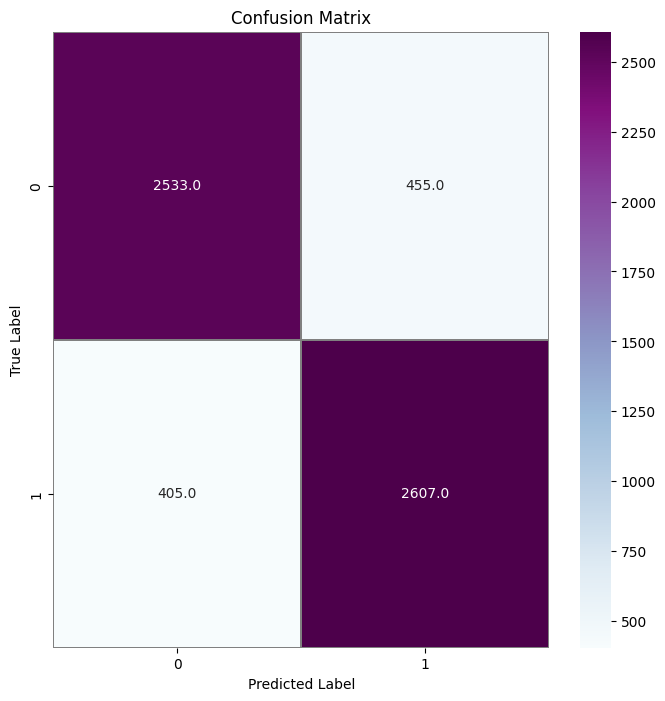

In [70]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

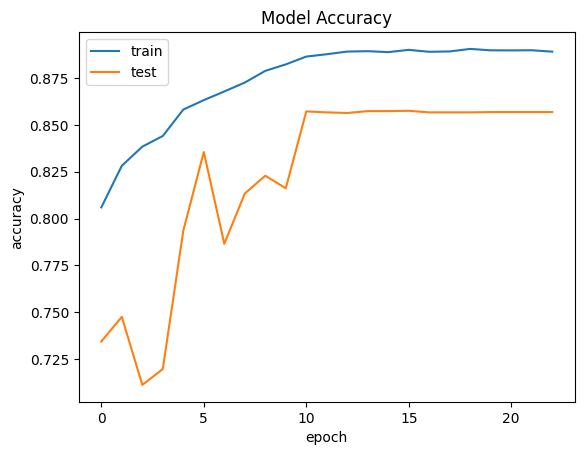

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

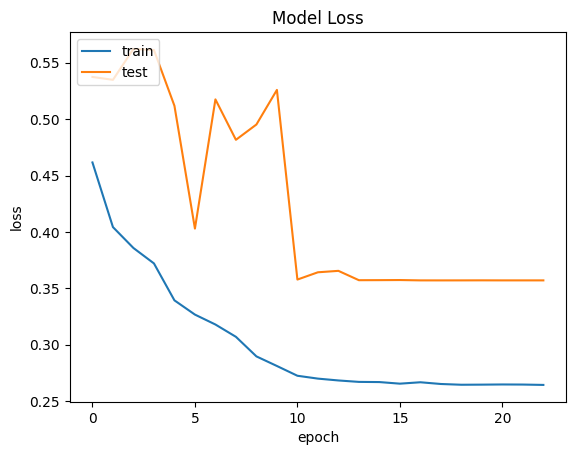

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
prediction = model.predict(X_test)
prediction

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[9.9996471e-01, 3.5310833e-05],
       [2.1283017e-01, 7.8716987e-01],
       [3.3921929e-04, 9.9966073e-01],
       ...,
       [2.3108185e-03, 9.9768925e-01],
       [8.0216050e-01, 1.9783944e-01],
       [5.8151165e-04, 9.9941850e-01]], dtype=float32)

### Testing the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
Predicted Diagnosis: Non-Cancerous
Calcification Type: No Calcification
True Diagnosis: Non-Cancerous


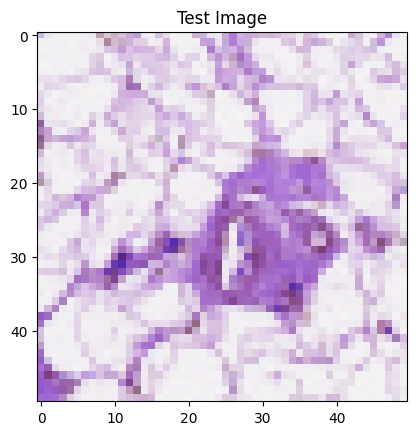

In [74]:
# Define a mapping of class indices to human-readable labels
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}

# Define a mapping of calcification types
calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}

# Define a function for plotting an image from an array
def img_plot(arr, index=0):
    # Set the title for the plot
    plt.title('Test Image')

    # Display the image at the specified index in the array
    plt.imshow(arr[index])

# Set the index value to 90
index = 90

# Plot an image from the X_test array using the img_plot function
img_plot(X_test, index)

# Extract a single image from X_test based on the specified index
input = X_test[index:index+1]

# Make a prediction using the CNN model and get the class with the highest probability
predicted_class_index = model.predict(input)[0].argmax()

# Get the true label from the y_test array
true_class_index = y_test[index].argmax()

# Get the predicted and true labels
predicted_label = class_labels[predicted_class_index]
true_label = class_labels[true_class_index]

# Get the calcification type based on the predicted class index (modify as needed)
calcification_type = calcification_types[predicted_class_index]

# Print the prediction result with calcification type
print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)

#### Saving the model

In [75]:
model.save('CNN_model.h5')

In [76]:
# prompt: store the model in google drive /content/drive/My Drive/dl-udemy/models

model.save('/content/drive/My Drive/dl-udemy/models/CNN_model.h5')

### Testing the Model on MINI DDSM Dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


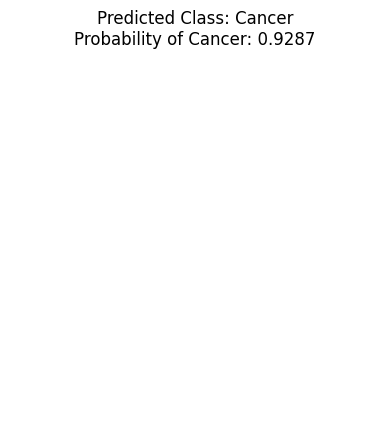

In [79]:
# Directory containing the images
imgs_dir = glob.glob('/content/drive/My Drive/dl-udemy/MINI-DDSM-Complete-PNG-16/Benign/**/*.png', recursive=True)

# Example image path
image_path = '/content/drive/My Drive/dl-udemy/MINI-DDSM-Complete-PNG-16/Benign/1768/A_1768_1.LEFT_CC.png'

# Define a function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(50, 50)):
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format
        img = cv2.resize(img, target_size)  # Resize to your target size
        img_array = img / 255.0  # Normalize pixel values

        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# Load and preprocess the example image
img_array = load_and_preprocess_image(image_path)

if img_array is not None:
    # Create a batch for prediction (even if it's a single image)
    img_batch = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_batch)

    # Assuming your model predicts binary probabilities, you can get the probability for "Cancer" class
    cancer_probability = predictions[0][0]  # Assuming "Cancer" is the first class

    # Get the predicted class label
    predicted_class = "Cancer" if cancer_probability >= 0.5 else "Normal"

    # Plot the image and display the predicted class and probability
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}\nProbability of Cancer: {cancer_probability:.4f}')
    plt.axis('off')
    plt.show()
else:
    print("Image loading and preprocessing failed.")